In [2]:
import re as re
import heapq as heapq
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MultiLabelBinarizer, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import random as random
from sklearn.preprocessing import StandardScaler
import pyarrow as pa
import pyarrow.parquet as pq
from sklearn.decomposition import PCA
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics 

## Initial Exploratory Data Analysis

In [3]:
tweets = pd.read_csv("../Data/Raw/dataset.csv", header = None, names=['sentiment', 'text'])

Tweet length statistics:
          char_length                                                      \
                count      mean        std  min   25%   50%    75%    max   
sentiment                                                                   
0             50000.0  73.55150  36.689293  6.0  43.0  69.0  103.0  186.0   
1             50000.0  73.93676  35.849812  7.0  44.0  69.0  103.0  166.0   

          word_count                                                  
               count      mean       std  min  25%   50%   75%   max  
sentiment                                                             
0            50000.0  13.44774  7.042649  1.0  8.0  12.0  19.0  35.0  
1            50000.0  12.79208  6.774854  1.0  7.0  12.0  18.0  35.0  


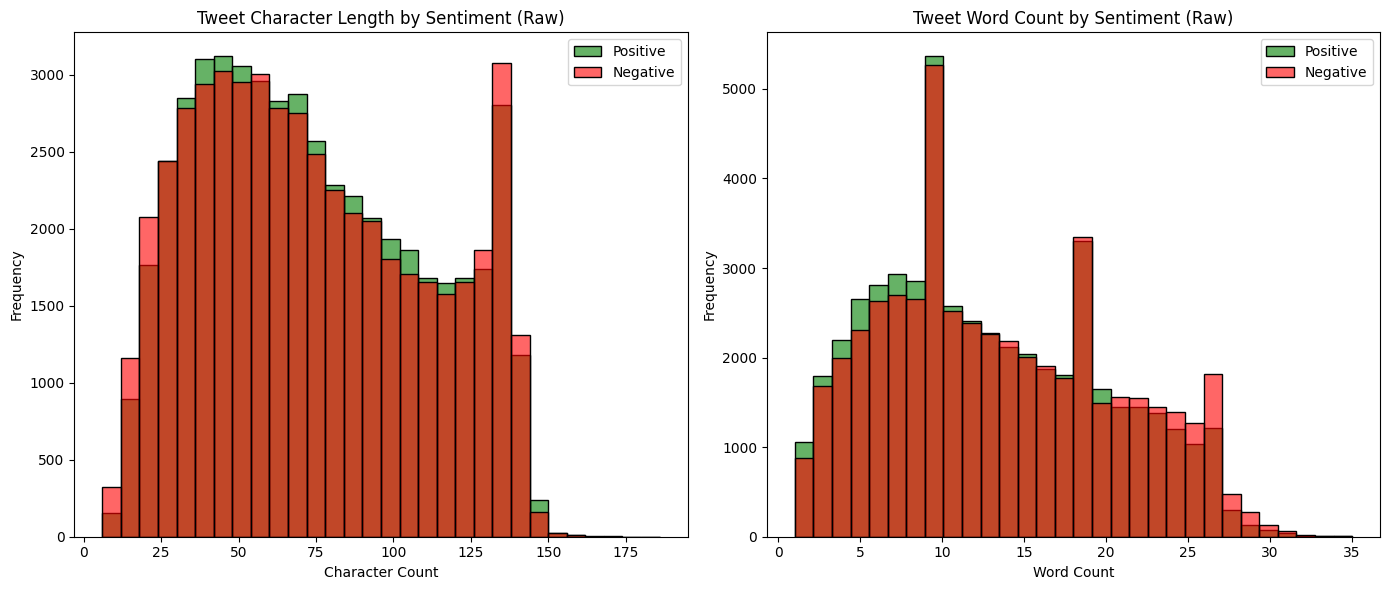

In [4]:
df = tweets.copy()

df['char_length'] = df['text'].str.len()
df['word_count'] = df['text'].str.split().str.len()

# Calculate statistics by sentiment
length_stats = df.groupby('sentiment')[['char_length', 'word_count']].describe()

print("Tweet length statistics:")
print(length_stats)

# Plot length distributions
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(data=df, x='char_length', hue='sentiment', 
            bins=30, alpha=0.6, palette=['red', 'green'])
plt.title('Tweet Character Length by Sentiment (Raw)')
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.legend(['Positive', 'Negative'])

plt.subplot(1, 2, 2)
sns.histplot(data=df, x='word_count', hue='sentiment', 
            bins=30, alpha=0.6, palette=['red', 'green'])
plt.title('Tweet Word Count by Sentiment (Raw)')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend(['Positive', 'Negative'])

plt.tight_layout()

Character count between negative and positive are similar, but negative sentiment tweets have a higher Word count on average 

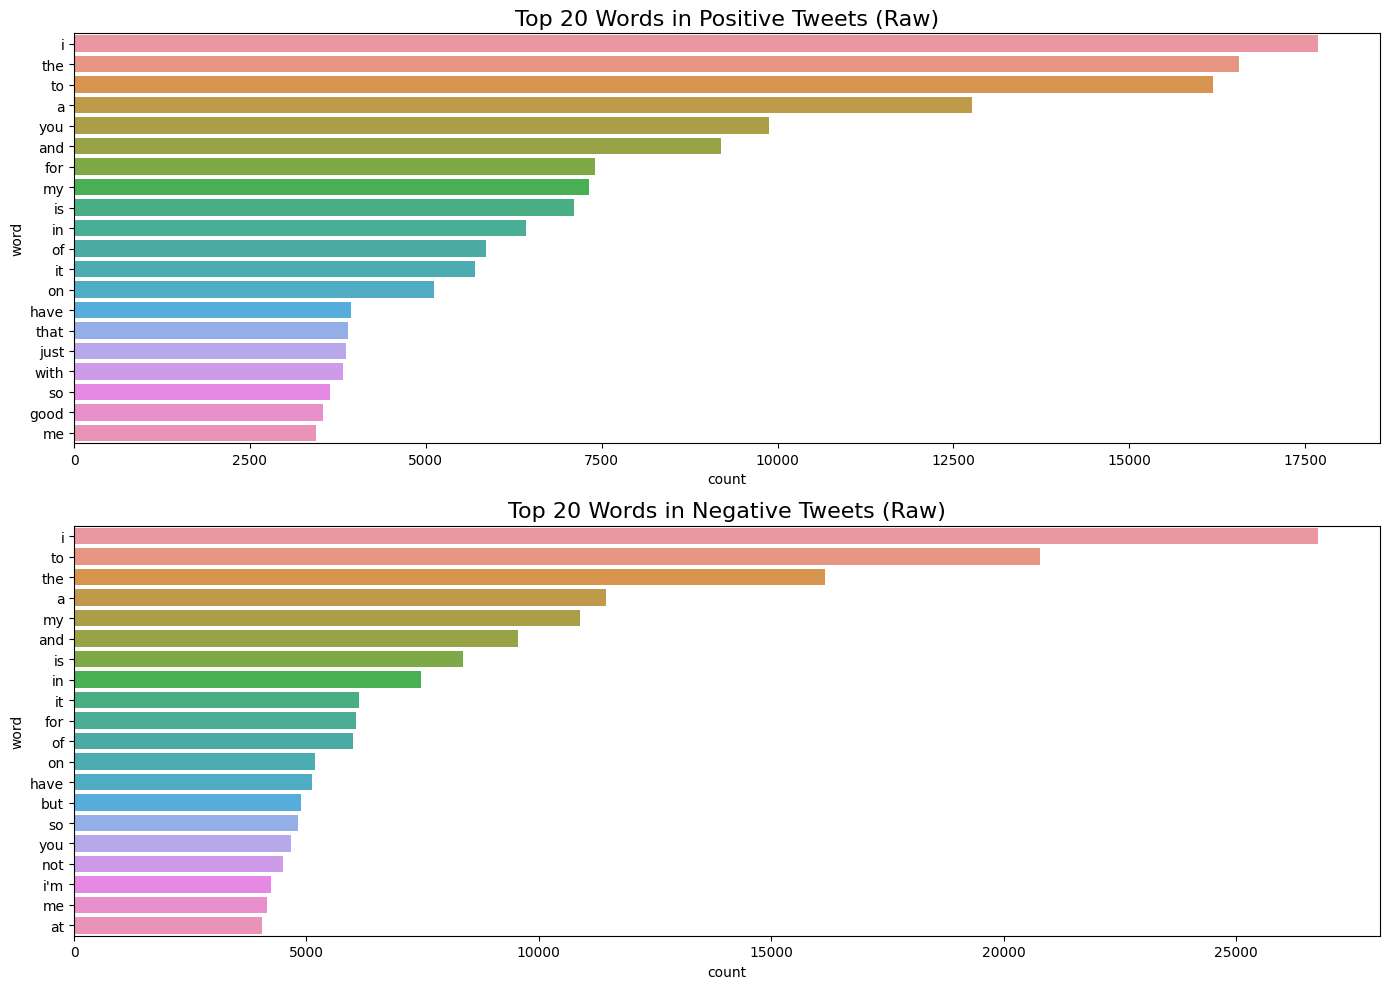

In [5]:
top_n = 20

# Function to extract words from a tweet
def get_words(text):
    return str(text).lower().split()

# Get all words by sentiment
positive_words = [word for tweet in tweets[tweets['sentiment'] == 1]['text'] for word in get_words(tweet)]
negative_words = [word for tweet in tweets[tweets['sentiment'] == 0]['text'] for word in get_words(tweet)]

# Count word frequencies
positive_word_counts = Counter(positive_words)
negative_word_counts = Counter(negative_words)
top_positive = positive_word_counts.most_common(top_n)
top_negative = negative_word_counts.most_common(top_n)
pos_df = pd.DataFrame(top_positive, columns=['word', 'count'])
neg_df = pd.DataFrame(top_negative, columns=['word', 'count'])

# Plot
plt.figure(figsize=(14, 10))

plt.subplot(2, 1, 1)
sns.barplot(x='count', y='word', data=pos_df)
plt.title(f'Top {top_n} Words in Positive Tweets (Raw)', fontsize=16)

plt.subplot(2, 1, 2)
sns.barplot(x='count', y='word', data=neg_df)
plt.title(f'Top {top_n} Words in Negative Tweets (Raw)', fontsize=16)

plt.tight_layout()

Top 3 words for both negative and positive tweets are the same. Thus they should not be used to predict the sentiment of a tweet. Stop Words should be removed

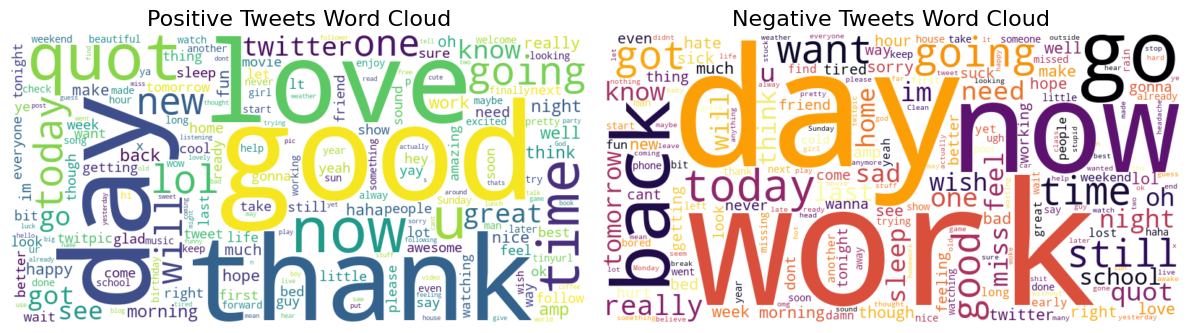

In [ ]:
### Word Cloud automatically removes Stop Words ###

# Combine all positive and negative tweets
positive_text = ' '.join(tweets[tweets['sentiment'] == 1]['text'].astype(str))
negative_text = ' '.join(tweets[tweets['sentiment'] == 0]['text'].astype(str))

# Create and plot positive word cloud
plt.figure(figsize=(12, 6))

wc_positive = WordCloud(
    background_color='white',
    max_words=200,
    width=800,
    height=400,
    collocations=False,
    colormap='viridis'
).generate(positive_text)

plt.subplot(1, 2, 1)
plt.imshow(wc_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Tweets Word Cloud', fontsize=16)

# Create and plot negative word cloud
wc_negative = WordCloud(
    background_color='white',
    max_words=200,
    width=800,
    height=400,
    collocations=False,
    colormap='inferno'
).generate(negative_text)

plt.subplot(1, 2, 2)
plt.imshow(wc_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Tweets Word Cloud', fontsize=16)

plt.tight_layout()

Other words such as "quot", "amp" and also slang stop words such as "u" and "im" should also be removed.

In [7]:
def classify_emoticons(text):

    # To account for reading :/ in http://
    text = re.sub(r'http\S+', '', text)

    positive_emoticons = [
        r'[:;=]-?[)D\]}]',  # Basic smiles :) ;) =) :D etc
        r'[:;=]-?[pP]',      # Tongue out :P
        r'<3',               # Heart
        r'\([:,;=]\)',       # (: (;
        r':-?[*]',           # Kisses
        r'[oO][._][oO]',     # o.O
        r'[;:]-?b',          # :b
        r'[:;=]-?[3]',       # Hearts/kisses
        r'[xX]D',            # Big grin XD
        r':-?[oO]',          # Surprised but often positive :O
        r'[;:]-?[\']',       # Happy tear/wink :\
        r'\^[._]\^',         # Happy eyes
        r'\^-?\^',           # Happy face
    ]
    
    negative_emoticons = [
        r'[:;=]-?[(\[{]',    # Frowns :( ;( =( etc
        r':[\/\\]',          # Skeptical/unsure
        r'>[:]',             # Angry
        r'[:;=]-?[xX]',      # Eyes shut in pain
        r'[:|]-?\|',         # Straight face (neutral/negative)
        r'[o0][._][o0]',     # Shocked or worried
        r'D-?[:;=]',         # Very unhappy
        r'v[._]v',           # Downcast eyes
        r'[x]-?[x]',         # Dead/unconscious
        r'[T]-?[T]',         # Crying T_T
        r'[;:][\']-?\(',     # Crying 
        r'[;:][_]-?\(',      # Crying hard
        r'-[._]-',           # Expressionless/sad
    ]
    
    pos_count = 0
    neg_count = 0
    
    # Check and count all instances of positive emoticons
    for pattern in positive_emoticons:
        matches = re.findall(pattern, text)
        pos_count += len(matches)
    
    # Check and count all instances of negative emoticons
    for pattern in negative_emoticons:
        matches = re.findall(pattern, text)
        neg_count += len(matches)
    
    return pos_count, neg_count

Percentage of tweets containing each Twitter element:
                    positive  negative
mentions              55.140    34.772
hashtags               2.038     1.584
urls                   6.020     2.714
exclamations          33.950    24.188
questions             11.100     9.684
positive_emoticons     3.258     2.162
negative_emoticons     1.588     1.598
ellipsis              12.844    16.254
all_caps              14.342    12.968
word_count           100.000   100.000


Average counts of Twitter elements per tweet:
                    positive  negative
mentions             0.58256   0.36148
hashtags             0.02354   0.01852
urls                 0.06176   0.02774
exclamations         0.61920   0.45334
questions            0.15402   0.14426
positive_emoticons   0.03470   0.02292
negative_emoticons   0.01876   0.01908
ellipsis             0.15414   0.19678
all_caps             0.24248   0.24160
word_count          12.79208  13.44774


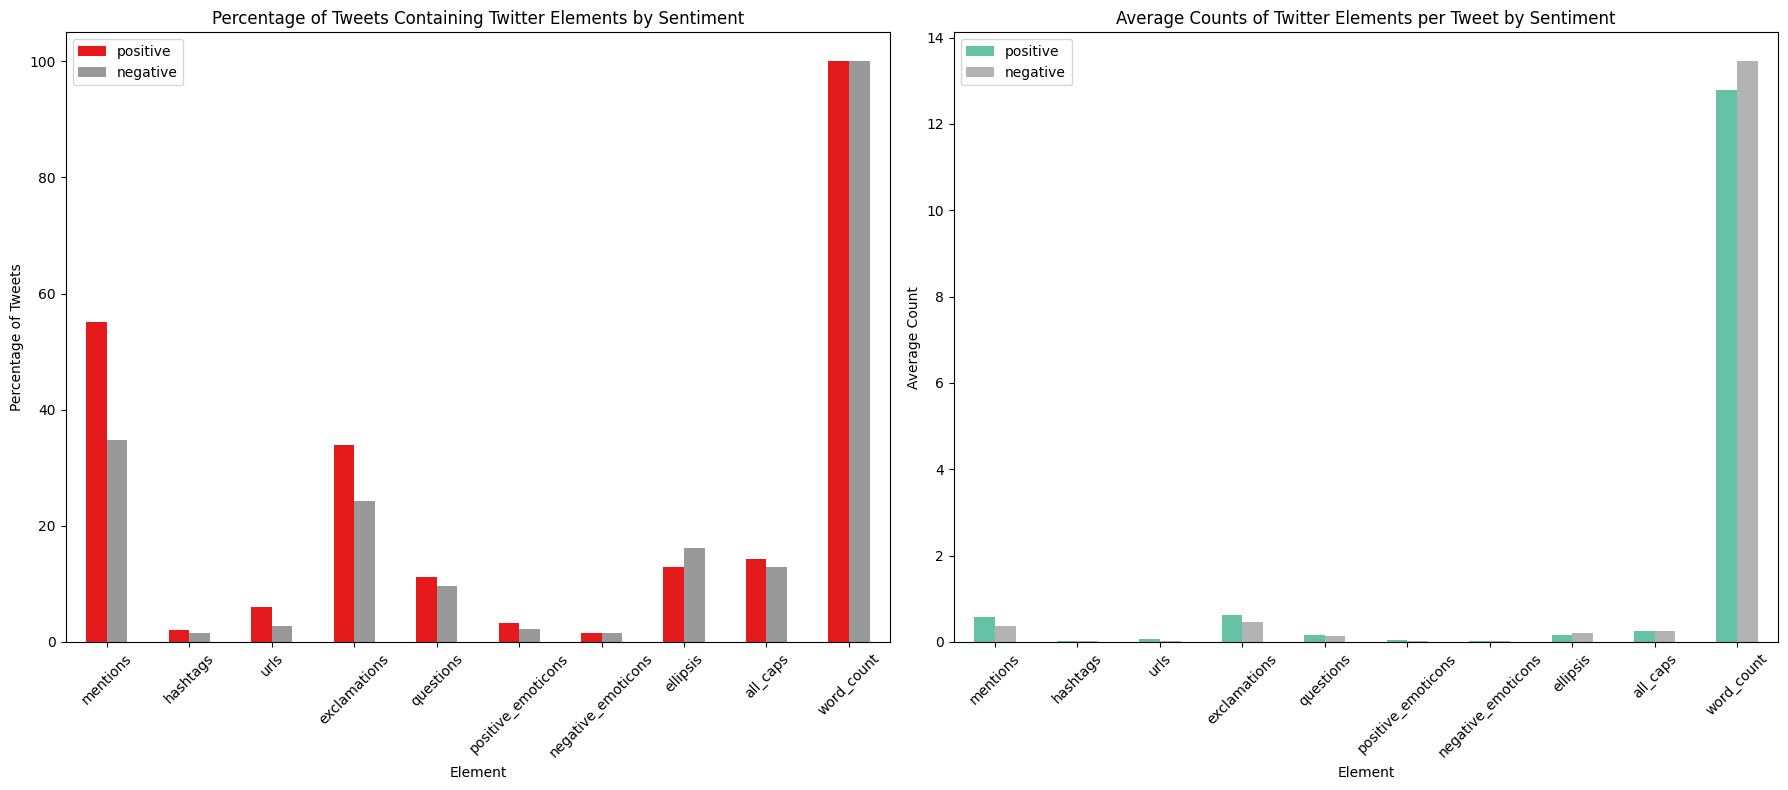

In [8]:
df = tweets.copy()

# Count Twitter-specific features
df['mentions'] = df['text'].apply(lambda x: len(re.findall(r'@\w+', str(x))))
df['hashtags'] = df['text'].apply(lambda x: len(re.findall(r'#\w+', str(x))))
df['urls'] = df['text'].apply(lambda x: len(re.findall(r'https?://\S+|www\.\S+|twitpic', str(x))))
df['exclamations'] = df['text'].apply(lambda x: len(re.findall(r'!', str(x))))
df['questions'] = df['text'].apply(lambda x: len(re.findall(r'\?', str(x))))
df['positive_emoticons'] = df['text'].apply(lambda x: classify_emoticons(x)[0])
df['negative_emoticons'] = df['text'].apply(lambda x: classify_emoticons(x)[1])
df['ellipsis'] = df['text'].apply(lambda x: len(re.findall(r'\.{3,}', str(x))))
df['all_caps'] = df['text'].apply(lambda x: len(re.findall(r'\b[A-Z]{2,}\b', str(x))))
df['word_count'] = df['text'].apply(lambda x: len(get_words(x)))

# Calculate percentage of tweets with each Twitter element
twitter_elements = ['mentions', 'hashtags', 'urls', 'exclamations', 'questions', 
                    'positive_emoticons', 'negative_emoticons', 'ellipsis', 'all_caps', 'word_count']

element_percentages = {}
for element in twitter_elements:
    pos_pct = (df[df['sentiment'] == 1][element] > 0).mean() * 100
    neg_pct = (df[df['sentiment'] == 0][element] > 0).mean() * 100
    element_percentages[element] = {'positive': pos_pct, 'negative': neg_pct}

element_df = pd.DataFrame(element_percentages).T

print("Percentage of tweets containing each Twitter element:")
print(element_df)
element_averages = {}
for element in twitter_elements:
    pos_avg = df[df['sentiment'] == 1][element].mean()
    neg_avg = df[df['sentiment'] == 0][element].mean()
    element_averages[element] = {'positive': pos_avg, 'negative': neg_avg}

average_df = pd.DataFrame(element_averages).T

print("\n")
print("Average counts of Twitter elements per tweet:")
print(average_df)

# Plotting graph side by side
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Plot percentage of tweets containing each Twitter element
element_df.plot(
    kind='bar',
    colormap='Set1',
    ax=axes[0],
    legend=True
)
axes[0].set_title('Percentage of Tweets Containing Twitter Elements by Sentiment')
axes[0].set_xlabel('Element')
axes[0].set_ylabel('Percentage of Tweets')
axes[0].tick_params(axis='x', rotation=45)

# Plot average counts of Twitter elements per tweet
average_df.plot(
    kind='bar',
    colormap='Set2',
    ax=axes[1],
    legend=True
)
axes[1].set_title('Average Counts of Twitter Elements per Tweet by Sentiment')
axes[1].set_xlabel('Element')
axes[1].set_ylabel('Average Count')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [9]:
from scipy.stats import ttest_ind

for element in twitter_elements:
    pos_values = df[df['sentiment'] == 1][element]
    neg_values = df[df['sentiment'] == 0][element]
    stat, p_value = ttest_ind(pos_values, neg_values, equal_var=False)
    print(f"{element}: T-stat={stat:.3f}, P-value={p_value:.5f}")

mentions: T-stat=63.503, P-value=0.00000
hashtags: T-stat=4.650, P-value=0.00000
urls: T-stat=25.408, P-value=0.00000
exclamations: T-stat=20.004, P-value=0.00000
questions: T-stat=2.126, P-value=0.03349
positive_emoticons: T-stat=10.447, P-value=0.00000
negative_emoticons: T-stat=-0.256, P-value=0.79765
ellipsis: T-stat=-14.442, P-value=0.00000
all_caps: T-stat=0.140, P-value=0.88896
word_count: T-stat=-15.003, P-value=0.00000


Features with Statistically Significant Differences (p-value < 0.05)
- Mentions, Hashtags, URLs, Exclamations, Questions, Positive Emoticons, Ellipsis, Word Count

Surprisingly, negative emoticons are about as frequent in positive tweets as those in negative tweets. Emoticons might not be a good indicator as positive and negative emtoticons can also be used sarcastically. Generalising it to simply counting the number of emoticons might be better.

## Data Cleaning/ Basic Feature Extraction

In [14]:
# Extracting relevant features

tweets['mentions'] = tweets['text'].apply(lambda x: len(re.findall(r'@\w+', str(x))))
tweets['hashtags'] = tweets['text'].apply(lambda x: len(re.findall(r'#\w+', str(x))))
tweets['urls'] = tweets['text'].apply(lambda x: len(re.findall(r'https?://\S+|www\.\S+|twitpic', str(x))))
tweets['exclamations'] = tweets['text'].apply(lambda x: len(re.findall(r'!', str(x))))
tweets['emoticons'] = tweets['text'].apply(lambda x: classify_emoticons(x)[0]+classify_emoticons(x)[1])
tweets['ellipsis'] = tweets['text'].apply(lambda x: len(re.findall(r'\.{3,}', str(x))))
tweets['word_count'] = tweets['text'].apply(lambda x: len(get_words(x)))

In [15]:
# Check what are considered stopwords

stop_words = set(stopwords.words('english'))
print(stop_words)

{'there', "they'll", 'each', "haven't", 'was', 'the', 'couldn', 'if', 'm', 'above', "you'll", 'ourselves', 'other', 'd', 't', 'now', 'between', 'is', 'weren', 'as', 'being', 'ma', "it'll", 'while', "wouldn't", 'which', 'or', 'by', 'in', 'shouldn', 'their', 'no', 'hers', 'more', 'both', 'can', 'a', 'your', 'down', 'will', 'ours', 'all', "aren't", 'have', 'him', "i'm", 'where', 'before', 'wouldn', "she'd", "she'll", "that'll", 'those', 'y', 'up', 'out', 'yours', 'after', 'mightn', 'they', 'here', 'my', 'who', 'against', 'isn', 'we', "i've", 'had', 'haven', 'whom', 'did', 'its', "i'll", 'what', 'of', 'under', 'but', 'mustn', 'hadn', 'been', 'she', 'through', 'then', 'about', 'himself', 'most', "mustn't", 'do', 'off', "he's", 'll', 'at', "they've", "you're", 'into', 'very', 'so', 'them', 'aren', 'i', 'from', 'am', "i'd", 'it', 'only', 'same', 'nor', 'during', 'don', 'having', 'doesn', 're', "needn't", 'just', "won't", 'doing', 'further', 'own', 'some', 'themselves', 'he', 'o', 'were', "has

In [20]:
# Remove irrelevant features

def remove_urls(text):
    return re.sub(r'http\S+', '', text)

def remove_amp(text):
    return re.sub(r'&\w+;', '', text)

def at_filter(text):
    return re.sub(r"@\w+", "", text)

def lower_case(text):
    return text.lower()

def remove_stopwords(text):
    # Remove stopwords 
    stop_words = set(stopwords.words('english'))
    
    # Words to add to stopwords based on earlier EDA
    add_words = {
        "day", "u",
        "ur", "aint",
        "im", "quot",
        "that's"
    }

    # Words to preserve 
    preserve_words = {
        "isn't", "is",
        "wasn't", "was",
        "aren't", "are",
        "doesn't", "does",
        "couldn't", "could",
        "won't", "will",
        "shouldn't", "should",
        "didn't", "did",
        "haven't", "have",
        "no", "not"
    }
    

    filtered_stopwords = (stop_words - preserve_words).union(add_words)

    filtered_tokens = [token for token in text if token not in filtered_stopwords]

    
    return filtered_tokens

In [17]:
tweets.head()

,sentiment,text,mentions,hashtags,urls,exclamations,emoticons,ellipsis,word_count
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",1,0,1,0,1,0,19
1,0,is upset that he can't update his Facebook by ...,0,0,0,1,0,1,21
2,0,@Kenichan I dived many times for the ball. Man...,1,0,0,0,0,0,18
3,0,my whole body feels itchy and like its on fire,0,0,0,0,0,0,10
4,0,"@nationwideclass no, it's not behaving at all....",1,0,0,0,0,0,21


In [21]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

tweets["text"] = tweets["text"].apply(lambda x: at_filter(x))
tweets["text"] = tweets["text"].apply(lambda x: remove_amp(x))
tweets["text"] = tweets["text"].apply(lambda x: remove_urls(x))
tweets["text"] = tweets["text"].apply(lambda x: lower_case(x))
tokenizer = TweetTokenizer()
tweets['processed_text'] = tweets['text'].apply(tokenizer.tokenize)
tweets['processed_text'] = tweets['processed_text'].apply(remove_stopwords)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alber\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alber\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alber\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [22]:
tweets.head()

,sentiment,text,mentions,hashtags,urls,exclamations,emoticons,ellipsis,word_count,processed_text
0,0,"- awww, that's a bummer. you shoulda got da...",1,0,1,0,1,0,19,"[-, awww, ,, bummer, ., shoulda, got, david, c..."
1,0,is upset that he can't update his facebook by ...,0,0,0,1,0,1,21,"[is, upset, can't, update, facebook, texting, ..."
2,0,i dived many times for the ball. managed to s...,1,0,0,0,0,0,18,"[dived, many, times, ball, ., managed, save, 5..."
3,0,my whole body feels itchy and like its on fire,0,0,0,0,0,0,10,"[whole, body, feels, itchy, like, fire]"
4,0,"no, it's not behaving at all. i'm mad. why am...",1,0,0,0,0,0,21,"[no, ,, not, behaving, ., mad, ., ?, can't, se..."


In [23]:
# lemmatizer

lemmatizer = WordNetLemmatizer()
def lemmatize_tokens(filtered_tokens):
  return ' '.join([lemmatizer.lemmatize(token) for token in filtered_tokens])

In [24]:
tweets['processed_text'] = tweets['processed_text'].apply(lemmatize_tokens)

In [25]:
print(tweets.isnull().sum())  # Check for null values

sentiment         0
text              0
mentions          0
hashtags          0
urls              0
exclamations      0
emoticons         0
ellipsis          0
word_count        0
processed_text    0
dtype: int64


In [26]:
tweets.shape

(100000, 10)

In [27]:
tweets.head()

,sentiment,text,mentions,hashtags,urls,exclamations,emoticons,ellipsis,word_count,processed_text
0,0,"- awww, that's a bummer. you shoulda got da...",1,0,1,0,1,0,19,"- awww , bummer . shoulda got david carr third..."
1,0,is upset that he can't update his facebook by ...,0,0,0,1,0,1,21,is upset can't update facebook texting ... mig...
2,0,i dived many times for the ball. managed to s...,1,0,0,0,0,0,18,dived many time ball . managed save 50 % rest ...
3,0,my whole body feels itchy and like its on fire,0,0,0,0,0,0,10,whole body feel itchy like fire
4,0,"no, it's not behaving at all. i'm mad. why am...",1,0,0,0,0,0,21,"no , not behaving . mad . ? can't see ."


In [ ]:
# Save as when needed

#tweets.to_csv("CleanedTweets.csv")

In [29]:
tweets = pd.read_csv('CleanedTweets.csv')

In [30]:
tweets.head()

,Unnamed: 0,sentiment,text,mentions,hashtags,urls,exclamations,emoticons,ellipsis,word_count,processed_text
0,0,0,"- awww, that's a bummer. you shoulda got da...",1,0,1,0,1,0,19,"- awww , bummer . shoulda got david carr third..."
1,1,0,is upset that he can't update his facebook by ...,0,0,0,1,0,1,21,is upset can't update facebook texting ... mig...
2,2,0,i dived many times for the ball. managed to s...,1,0,0,0,0,0,18,dived many time ball . managed save 50 % rest ...
3,3,0,my whole body feels itchy and like its on fire,0,0,0,0,0,0,10,whole body feel itchy like fire
4,4,0,"no, it's not behaving at all. i'm mad. why am...",1,0,0,0,0,0,21,"no , not behaving . mad . ? can't see ."
